<a href="https://colab.research.google.com/github/nrjcs/iitpbse/blob/master/LSTM_AEMO_Time_Series_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://keras.io/api/
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from numpy import array

import pandas as pd
# https://pandas.pydata.org/docs/

import numpy as np
# https://numpy.org/doc/stable/about.html

from math import sqrt
# https://docs.python.org/3/library/math.html
from datetime import datetime
# https://docs.python.org/3/library/datetime.html

from matplotlib import pyplot as plt
# https://matplotlib.org/index.html
import seaborn as sns
# https://seaborn.pydata.org/

from sklearn.metrics import mean_squared_error
# https://scikit-learn.org/stable/getting_started.html




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/power_consumption_JAN.csv')


In [4]:
data.head()

,Unnamed: 0,TOTALDEMAND,Months,Quarters,date_time,days,weekday
0,0,7166.97,1,1.0,2013-01-01 00:30:00,1,1
1,1,6928.11,1,1.0,2013-01-01 01:00:00,1,1
2,2,6541.21,1,1.0,2013-01-01 01:30:00,1,1
3,3,6253.60,1,1.0,2013-01-01 02:00:00,1,1
4,4,6003.44,1,1.0,2013-01-01 02:30:00,1,1


In [5]:
data.dtypes

Unnamed: 0       int64
TOTALDEMAND    float64
Months           int64
Quarters       float64
date_time       object
days             int64
weekday          int64
dtype: object

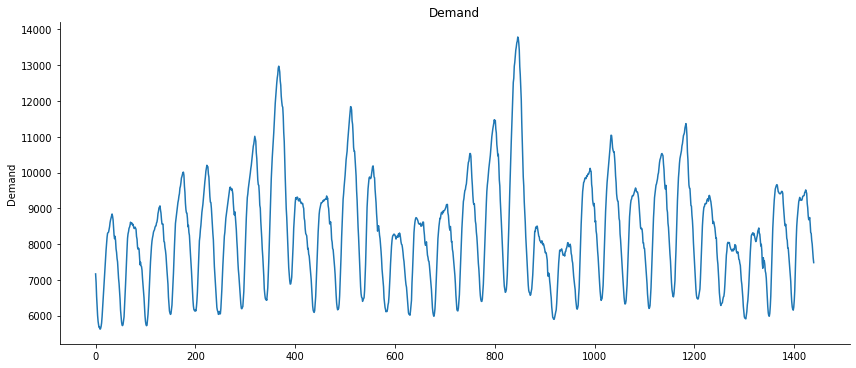

In [20]:
#Passenger PLOT
data['TOTALDEMAND'][0:1440].plot(figsize=(12,5))
plt.ylabel('Demand')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Demand')
sns.despine(top=True)
plt.show()

# Vanila LSTM

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [8]:
raw_seq = data['TOTALDEMAND']
trainLen = int(len(data['TOTALDEMAND']) * 0.8)
train = raw_seq[:trainLen]
test = raw_seq[trainLen:]

In [9]:
trainLen

3417

In [10]:
# choose a number of time steps
n_steps = 48

In [11]:
# split into samples
X, y = split_sequence(train, n_steps)

In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [13]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [15]:
# fit model
history = model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
106/106 [==============================] - 3s 25ms/step - loss: 9312575.0000
Epoch 2/200
106/106 [==============================] - 2s 24ms/step - loss: 7517100.5000
Epoch 3/200
106/106 [==============================] - 2s 21ms/step - loss: 6013292.0000
Epoch 4/200
106/106 [==============================] - 2s 21ms/step - loss: 4769386.0000
Epoch 5/200
106/106 [==============================] - 2s 22ms/step - loss: 3750580.0000
Epoch 6/200
106/106 [==============================] - 2s 21ms/step - loss: 2925887.7500
Epoch 7/200
106/106 [==============================] - 2s 21ms/step - loss: 2270510.0000
Epoch 8/200
106/106 [==============================] - 2s 21ms/step - loss: 1755024.8750
Epoch 9/200
106/106 [==============================] - 2s 21ms/step - loss: 1358308.2500
Epoch 10/200
106/106 [==============================] - 3s 24ms/step - loss: 1056636.8750
Epoch 11/200
106/106 [==============================] - 3s 25ms/step - loss: 831952.1875
Epoch 12/200
106/106

dict_keys(['loss'])


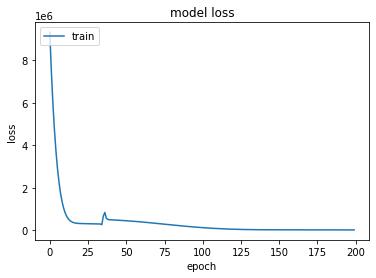

In [16]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
test = test.reset_index(drop = True)

In [18]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [19]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)

Test RMSE: 132.098


# Stacked LSTM

Stacked LSTMs or Deep LSTMs were introduced by Graves, et al. in their application of LSTMs to speech recognition, beating a benchmark on a challenging standard problem.

## Architecture of stacked LSTM

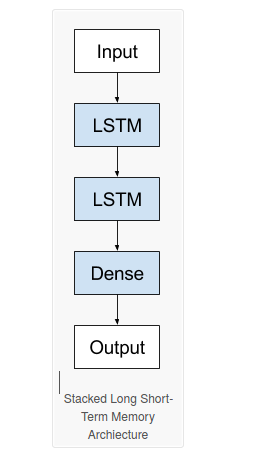

In [23]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
# fit model
history= model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
106/106 [==============================] - 5s 43ms/step - loss: 99996040.0000
Epoch 2/200
106/106 [==============================] - 5s 45ms/step - loss: 649108352.0000
Epoch 3/200
106/106 [==============================] - 5s 50ms/step - loss: 58881844.0000
Epoch 4/200
106/106 [==============================] - 5s 46ms/step - loss: 29888058.0000
Epoch 5/200
106/106 [==============================] - 5s 47ms/step - loss: 25697998.0000
Epoch 6/200
106/106 [==============================] - 5s 47ms/step - loss: 37328280.0000
Epoch 7/200
106/106 [==============================] - 5s 48ms/step - loss: 25691366.0000
Epoch 8/200
106/106 [==============================] - 5s 51ms/step - loss: 10856692.0000
Epoch 9/200
106/106 [==============================] - 5s 51ms/step - loss: 12927112.0000
Epoch 10/200
106/106 [==============================] - 6s 58ms/step - loss: 8970732.0000
Epoch 11/200
106/106 [==============================] - 6s 53ms/step - loss: 7684924.0000
Epoch 12/

dict_keys(['loss'])


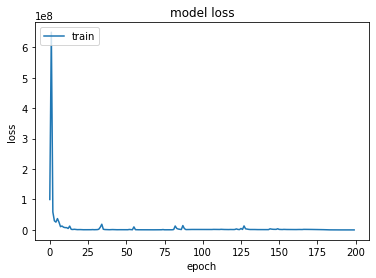

In [25]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [27]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)

Test RMSE: 337.512



# Bidirectional LSTM

On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

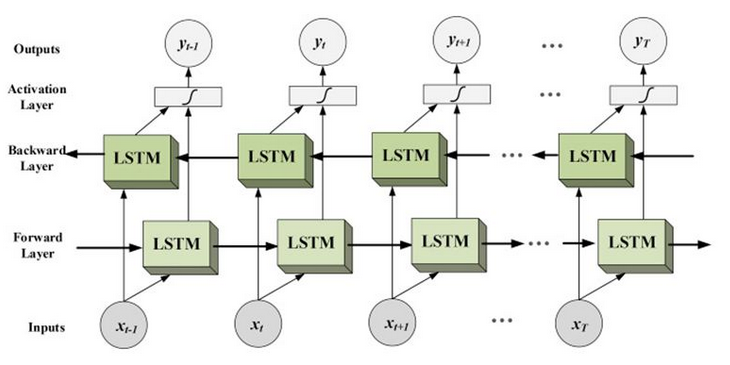

In [ ]:
from keras.layers import Bidirectional

In [ ]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
history = model.fit(X, y, epochs=200, verbose=0)

dict_keys(['loss'])


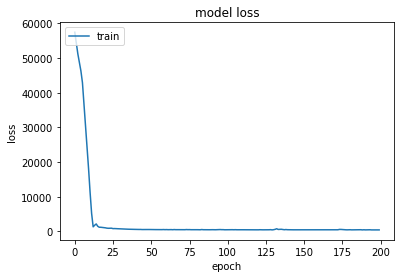

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [ ]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)

Test RMSE: 42.350
